In [1]:
# run stopwatch
from tools import Stopwatch
stopwatch = Stopwatch()
start = stopwatch.start()

### Load libraries, functions, palette, theme

In [2]:
%run _libraries.ipynb

In [3]:
%run _functions.ipynb

In [4]:
dir_current = '02-feature-engineering'

In [5]:
dir_load_files = 'files/'

In [6]:
dir_save_files = 'files/'

In [7]:
save_img = 'docs/img/' + dir_current + '/'

In [8]:
session_name = dir_current

# Section II. Feature Engineering

## Load Saved Section if exists

## Load Data

In [9]:
train = loadit('train_raw', dir=dir_load_files)

In [10]:
valid = loadit('valid_raw', dir=dir_load_files)

In [11]:
test = loadit('test_raw', dir=dir_load_files)

## Feature Engineering

In [12]:
train.head(3)

,temperature,humidity,windspeed,generaldiffuseflows,diffuseflows,target1,target2,target3,minute,hour,...,weekday,week,month,year_month,year_day,count_elmnts_by_day,target1_diff,target1_returns,target1_volatility,p
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,0,...,6,52,1,2017-01,2017-01-01,1,NaN,NaN,NaN,NaN
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,10,0,...,6,52,1,2017-01,2017-01-01,2,-4241.01266,-12.453167,155.081364,-0.124532
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,20,0,...,6,52,1,2017-01,2017-01-01,3,-686.58227,-2.302833,5.303038,-0.023028


#### Minute of day

In [13]:
%%time
for i in train['day_of_year']:
    leng_i = len(train[train['day_of_year']==i])
    values_ = arange(0, leng_i*10, 10)
    train.loc[train['day_of_year']==i, 'minute_of_day'] = values_

CPU times: user 49.5 s, sys: 546 ms, total: 50 s
Wall time: 51.8 s


In [14]:
%%time
for i in valid['day_of_year']:
    leng_i = len(valid[valid['day_of_year']==i])
    values_ = arange(0, leng_i*10, 10)
    valid.loc[valid['day_of_year']==i, 'minute_of_day'] = values_

CPU times: user 6.68 s, sys: 84.4 ms, total: 6.77 s
Wall time: 7.02 s


In [15]:
train['minute_of_day']

2017-01-01 00:00:00       0.0
2017-01-01 00:10:00      10.0
2017-01-01 00:20:00      20.0
2017-01-01 00:30:00      30.0
2017-01-01 00:40:00      40.0
                        ...  
2017-07-31 23:10:00    1390.0
2017-07-31 23:20:00    1400.0
2017-07-31 23:30:00    1410.0
2017-07-31 23:40:00    1420.0
2017-07-31 23:50:00    1430.0
Freq: 10min, Name: minute_of_day, Length: 30528, dtype: float64

In [16]:
valid['minute_of_day']

2017-08-01 00:00:00       0.0
2017-08-01 00:10:00      10.0
2017-08-01 00:20:00      20.0
2017-08-01 00:30:00      30.0
2017-08-01 00:40:00      40.0
                        ...  
2017-08-31 23:10:00    1390.0
2017-08-31 23:20:00    1400.0
2017-08-31 23:30:00    1410.0
2017-08-31 23:40:00    1420.0
2017-08-31 23:50:00    1430.0
Freq: 10min, Name: minute_of_day, Length: 4464, dtype: float64

<Axes: xlabel='minute_of_day', ylabel='target1'>

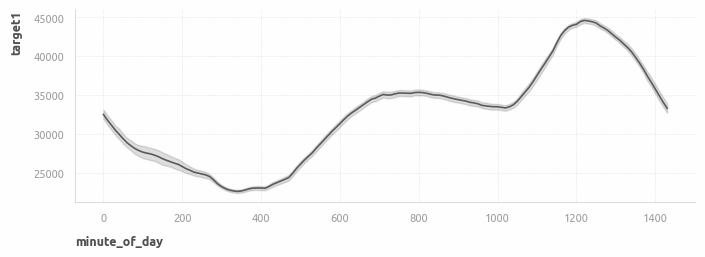

In [17]:
sns.lineplot(
    data=train,
    x='minute_of_day',
    y='target1'
)

#### Features 'is_Friday' and 'is_Sunday'

In [18]:
train['is_Friday'] = (train['weekday']==4).astype(int)

In [19]:
train['is_Sunday'] = (train['weekday']==6).astype(int)

In [20]:
valid['is_Friday'] = (valid['weekday']==4).astype(int)

In [21]:
valid['is_Sunday'] = (valid['weekday']==6).astype(int)

#### Feature 'is_31'

In [22]:
train['is_31'] = (train['day']==31).astype(int)

In [23]:
valid['is_31'] = (valid['day']==31).astype(int)

#### Cumulative average of Target1

In [24]:
train['target1_cum_avg'] = \
    (train.groupby('day_of_year')['target1'].cumsum().values
     / train['count_elmnts_by_day'].values)

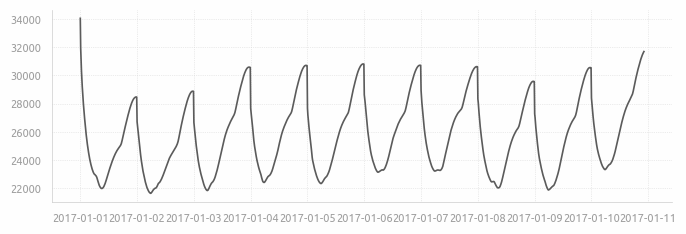

In [25]:
plt.plot(train['target1_cum_avg'][:143*10]);

In [26]:
train['target1_cum_avg'] = train['target1_cum_avg'].shift(1)

In [27]:
train[['target1', 'target1_cum_avg']]

,target1,target1_cum_avg
2017-01-01 00:00:00,34055.69620,NaN
2017-01-01 00:10:00,29814.68354,34055.696200
2017-01-01 00:20:00,29128.10127,31935.189870
2017-01-01 00:30:00,28228.86076,30999.493670
2017-01-01 00:40:00,27335.69620,30306.835442
...,...,...
2017-07-31 23:10:00,43407.30897,38477.324984
2017-07-31 23:20:00,42507.90698,38512.539156
2017-07-31 23:30:00,41659.53488,38540.875098
2017-07-31 23:40:00,40843.05648,38562.837490


In [28]:
scipy.stats.pearsonr(
    train['target1_cum_avg'][1:],
    train['target1'][1:]
)

PearsonRResult(statistic=0.5919214986544622, pvalue=0.0)

In [29]:
scipy.stats.pearsonr(
    train['target1_cum_avg'].shift()[2:],
    train['target1_cum_avg'][2:]
)

PearsonRResult(statistic=0.997255936836215, pvalue=0.0)

#### Median for previous minutes

Value of 'target1' from previous month day-by-day

In [30]:
train['target1_previous_month'] = generate_feature_by_minutes(train, 'target1', '2017-01')

In [31]:
train['target1_previous_month']

2017-01-01 00:00:00            NaN
2017-01-01 00:10:00            NaN
2017-01-01 00:20:00            NaN
2017-01-01 00:30:00            NaN
2017-01-01 00:40:00            NaN
                          ...     
2017-07-31 23:10:00    40205.56291
2017-07-31 23:20:00    39423.57616
2017-07-31 23:30:00    38883.17881
2017-07-31 23:40:00    38107.54967
2017-07-31 23:50:00    37312.84768
Freq: 10min, Name: target1_previous_month, Length: 30528, dtype: float64

In [32]:
len_values_of_the_first_month = len(train.loc['2017-01'])

In [33]:
len_values_of_the_first_month

4464

In [34]:
train['target1_previous_month'][len_values_of_the_first_month-1:]

2017-01-31 23:50:00            NaN
2017-02-01 00:00:00    34055.69620
2017-02-01 00:10:00    29814.68354
2017-02-01 00:20:00    29128.10127
2017-02-01 00:30:00    28228.86076
                          ...     
2017-07-31 23:10:00    40205.56291
2017-07-31 23:20:00    39423.57616
2017-07-31 23:30:00    38883.17881
2017-07-31 23:40:00    38107.54967
2017-07-31 23:50:00    37312.84768
Freq: 10min, Name: target1_previous_month, Length: 26065, dtype: float64

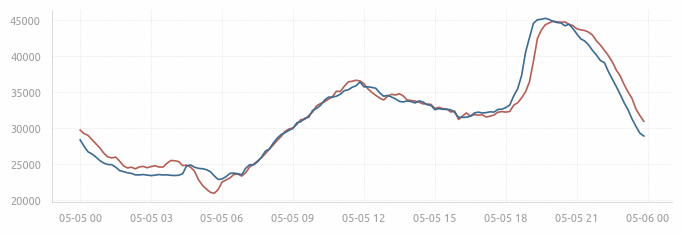

In [35]:
plt.plot(train.loc['2017-05-05', 'target1'], color=palette[1])
plt.plot(train.loc['2017-05-05', 'target1_previous_month'], color=palette[2])

In [36]:
valid['target1_previous_month'] = train.loc['2017-07-01':, 'target1'].values

In [37]:
valid

,temperature,humidity,windspeed,generaldiffuseflows,diffuseflows,target1,target2,target3,minute,hour,...,week,month,year_month,year_day,count_elmnts_by_day,minute_of_day,is_Friday,is_Sunday,is_31,target1_previous_month
2017-08-01 00:00:00,24.82,77.2,4.903,0.099,0.082,38517.20311,26979.09187,31008.90282,0,0,...,31,8,2017-08,2017-08-01,1,0.0,0,0,0,36384.31894
2017-08-01 00:10:00,24.72,77.7,4.906,0.059,0.141,37973.80688,26416.47307,30713.98119,10,0,...,31,8,2017-08,2017-08-01,2,10.0,0,0,0,35689.03654
2017-08-01 00:20:00,24.64,77.7,4.904,0.062,0.156,37308.94562,26192.18585,30178.30721,20,0,...,31,8,2017-08,2017-08-01,3,20.0,0,0,0,34751.36213
2017-08-01 00:30:00,24.62,77.6,4.904,0.062,0.130,36164.61709,25599.15523,29666.70846,30,0,...,31,8,2017-08,2017-08-01,4,30.0,0,0,0,33954.01993
2017-08-01 00:40:00,24.59,77.7,4.907,0.073,0.144,35678.75694,25344.45618,29413.91850,40,0,...,31,8,2017-08,2017-08-01,5,40.0,0,0,0,33411.82724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31 23:10:00,22.31,72.6,4.920,0.095,0.078,38619.48946,22713.83316,19976.42633,10,23,...,35,8,2017-08,2017-08-31,140,1390.0,0,0,1,43407.30897
2017-08-31 23:20:00,22.36,72.4,4.919,0.080,0.122,38370.16648,22006.75818,19476.86520,20,23,...,35,8,2017-08,2017-08-31,141,1400.0,0,0,1,42507.90698
2017-08-31 23:30:00,22.34,72.1,4.920,0.102,0.122,37724.48391,21790.07392,19320.37618,30,23,...,35,8,2017-08,2017-08-31,142,1410.0,0,0,1,41659.53488
2017-08-31 23:40:00,22.26,73.0,4.922,0.058,0.130,36874.22863,21265.46990,19133.79310,40,23,...,35,8,2017-08,2017-08-31,143,1420.0,0,0,1,40843.05648


## Save Data

In [38]:
saveit(train, 'train_preprocessed', dir_save_files)

File 'train_preprocessed.pkl' saved in directory 'files/'


In [39]:
saveit(valid, 'valid_preprocessed', dir_save_files)

File 'valid_preprocessed.pkl' saved in directory 'files/'


In [40]:
saveit(test, 'test_preprocessed', dir_save_files)

File 'test_preprocessed.pkl' saved in directory 'files/'


### Save Session

In [42]:
save_session(session_name)

### Execution time

In [43]:
print(f'Execution time: {stopwatch.stop(start)}')

Execution time: 0:02:09
